# Machine Learning Data Science Project
This project involves the classification and prediction of insurance claims using various machine learning algorithms. The goal is to build a model that can accurately predict whether an insurance claim will be made based on the provided features.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
import joblib

# Set seaborn style
sns.set(style="darkgrid")

In [2]:
# Function to load CSV files
def load_csv(file_path):
    try:
        data = pd.read_csv(file_path)
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except pd.errors.ParserError:
        print(f"Error parsing the CSV file: {file_path}")
        return None

# Load the data
train_data = load_csv('train.csv')
test_data = load_csv('test.csv')

# Function to display data summary
def display_data_summary(data, num_rows=5):
    print("First Few Rows:")
    print(data.head(num_rows))
    print("\nData Types:")
    print(data.dtypes)
    print("\nData Shape:")
    print(data.shape)
    print("\nMissing Values:")
    print(data.isnull().sum())
    print("\nSummary Statistics:")
    print(data.describe())
    print("\nInfo:")
    print(data.info())
    print("\nColumns:")
    print(data.columns)
    print("\nDuplicate Rows:")
    print(data.duplicated().sum())

# Display training data summary
print("Training Data Summary:")
display_data_summary(train_data)

# Display test data summary
print("\nTest Data Summary:")
display_data_summary(test_data)

Training Data Summary:
First Few Rows:
  policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0   ID00001       0.515874        0.05             0.644231           C1   
1   ID00002       0.672619        0.02             0.375000           C2   
2   ID00003       0.841110        0.02             0.384615           C3   
3   ID00004       0.900277        0.11             0.432692           C4   
4   ID00005       0.596403        0.11             0.634615           C5   

   population_density  make segment model fuel_type  ... is_brake_assist  \
0                4990     1       A    M1       CNG  ...              No   
1               27003     1       A    M1       CNG  ...              No   
2                4076     1       A    M1       CNG  ...              No   
3               21622     1      C1    M2    Petrol  ...             Yes   
4               34738     2       A    M3    Petrol  ...              No   

  is_power_door_locks is_central_locking  is_po

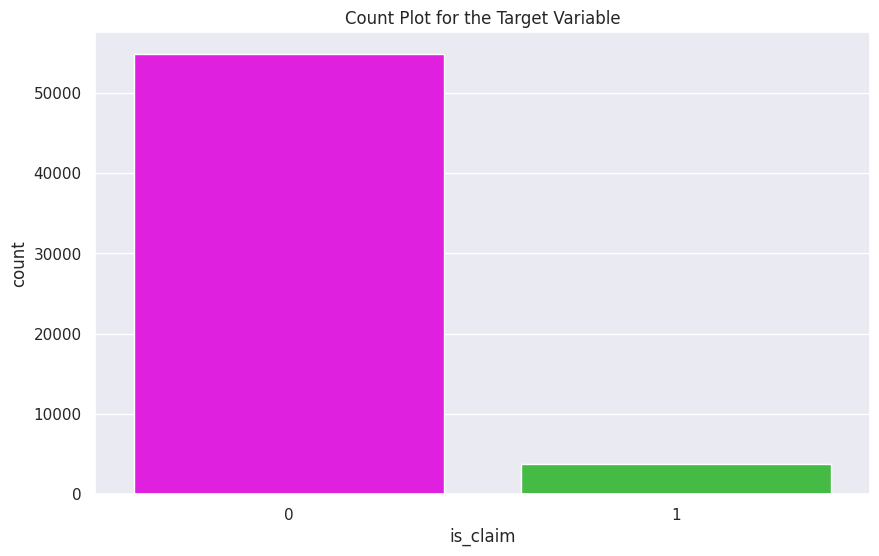

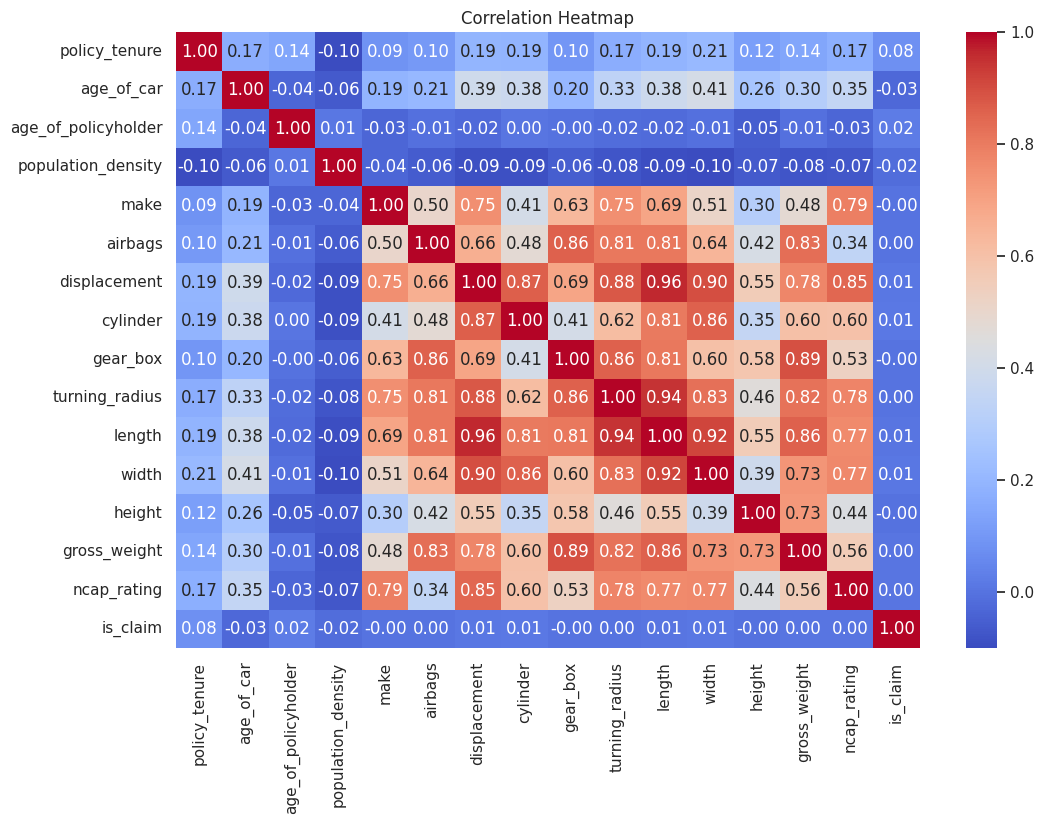

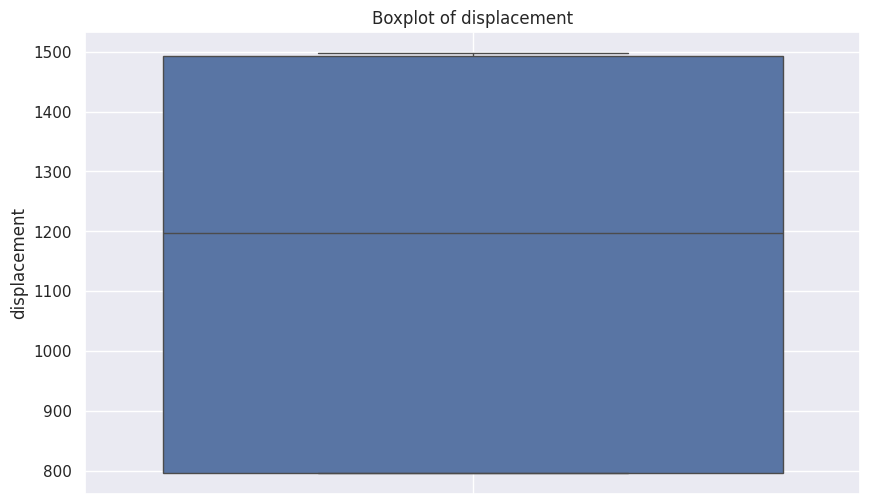

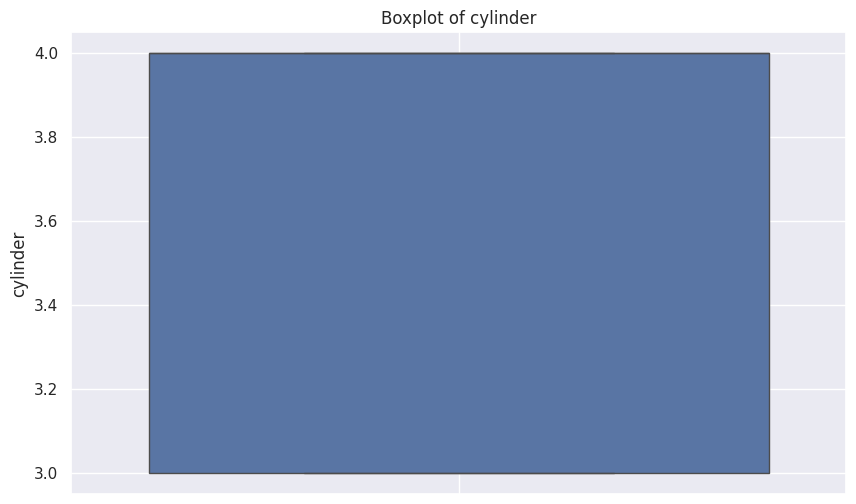

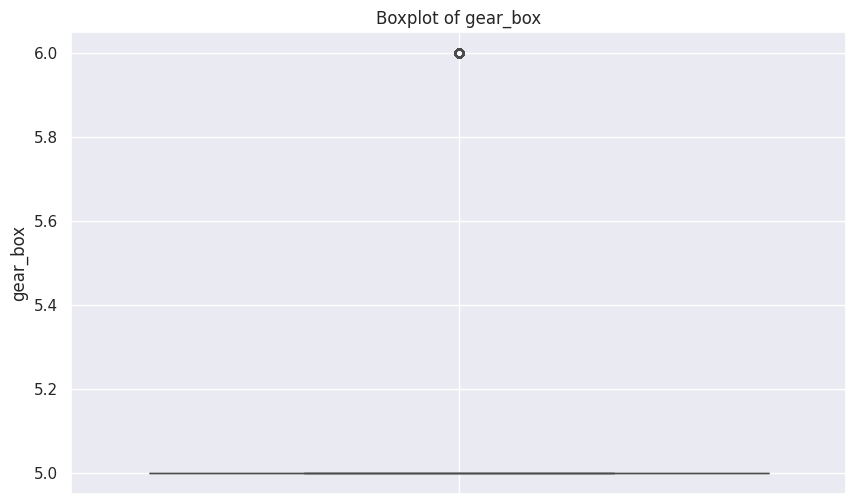

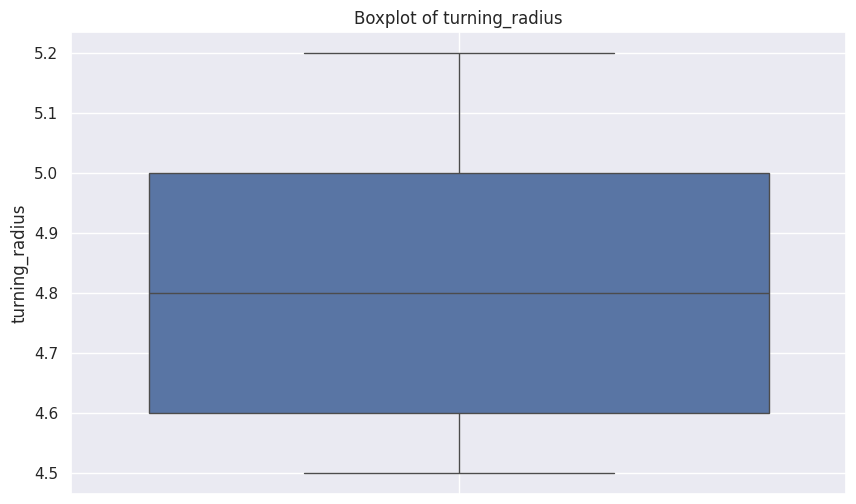

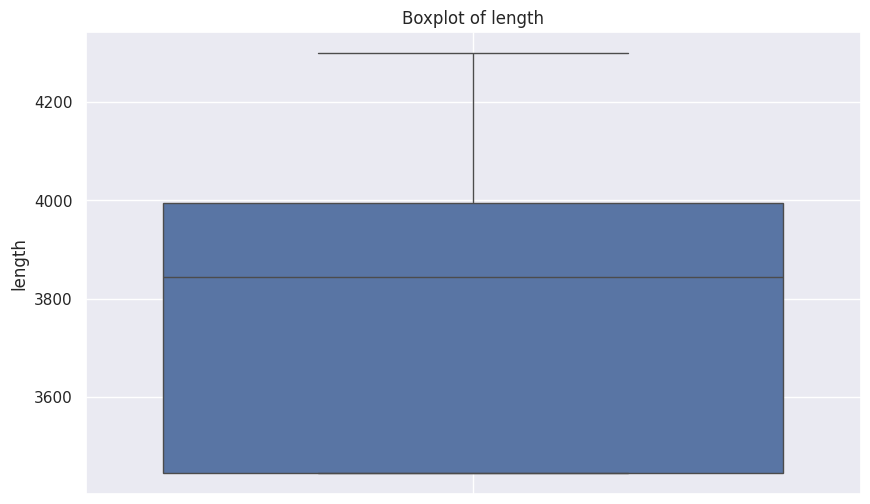

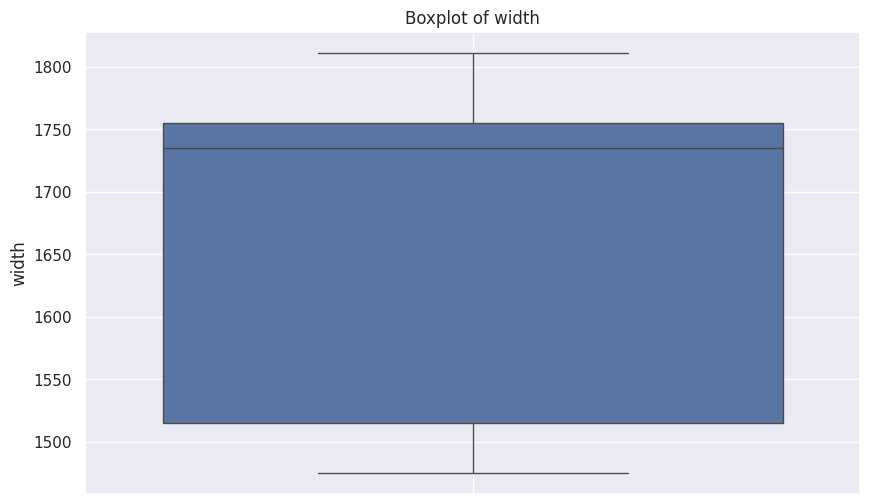

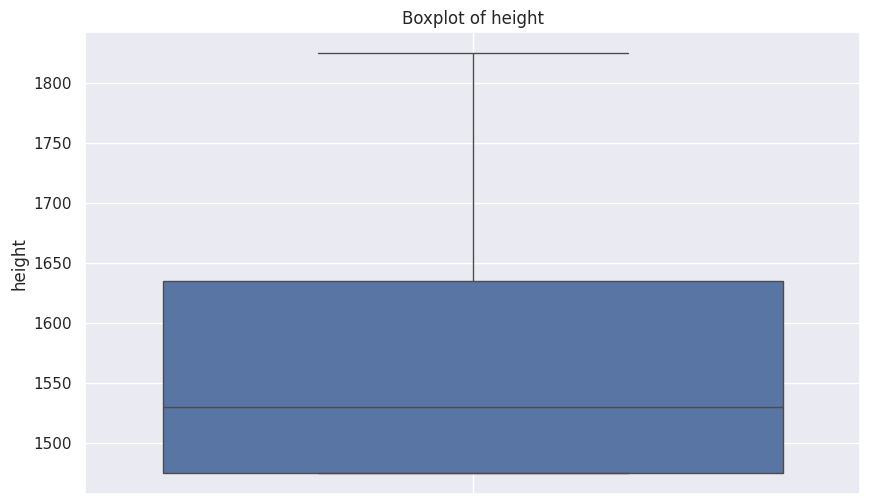

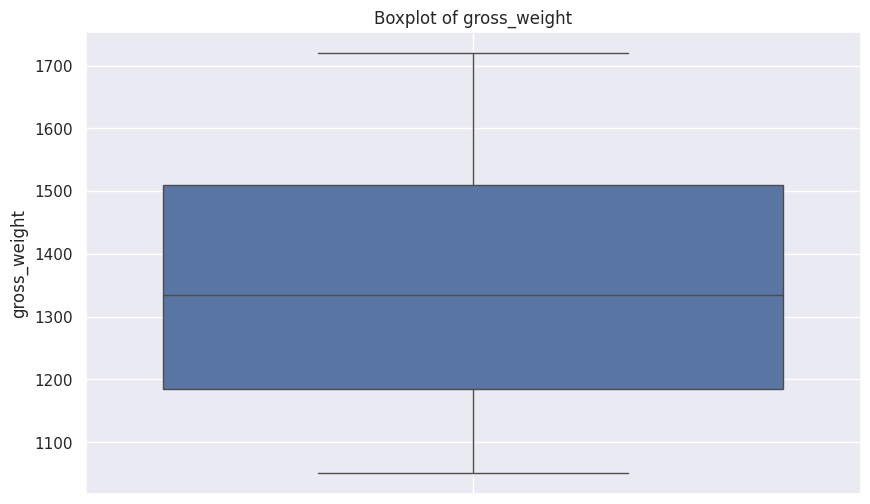

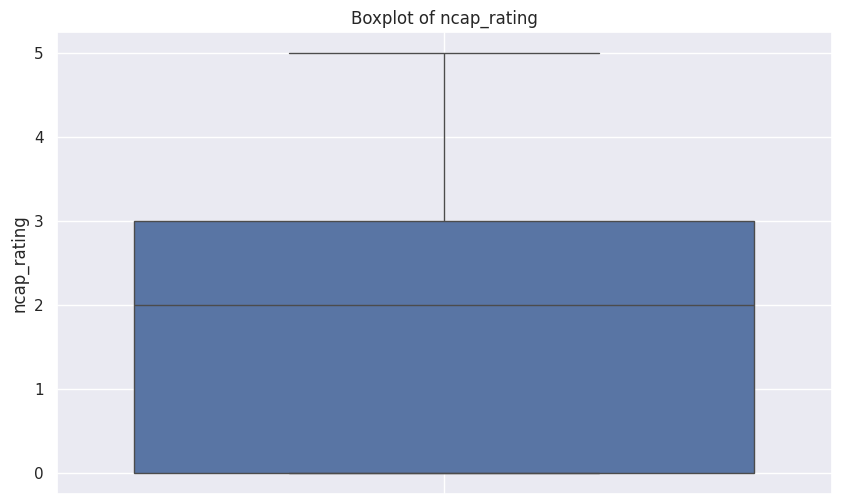

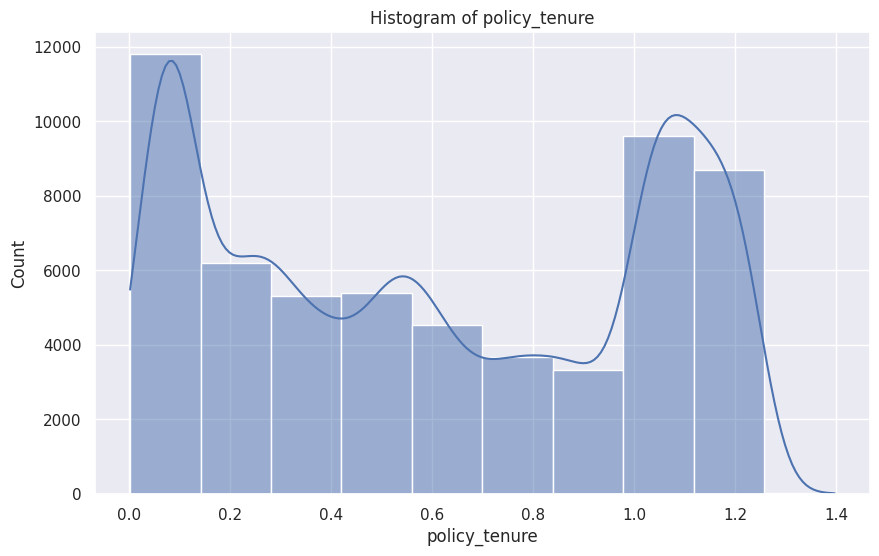

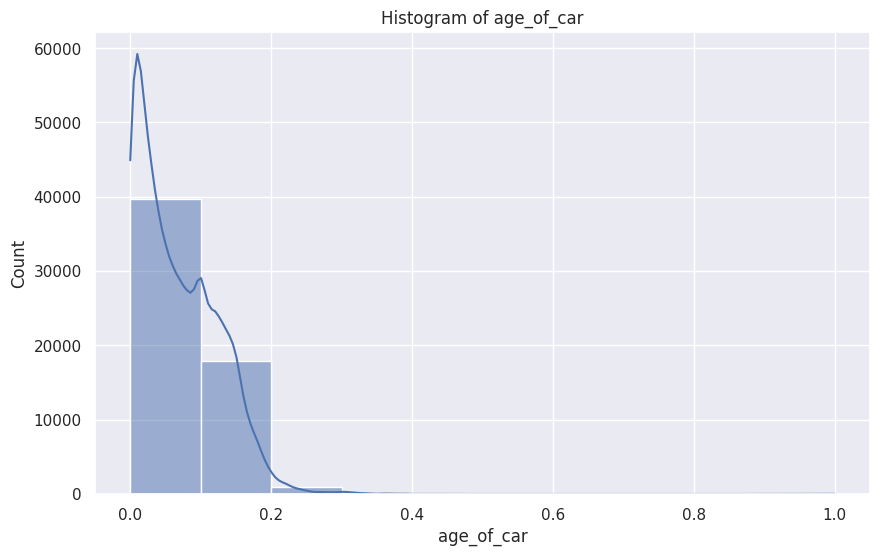

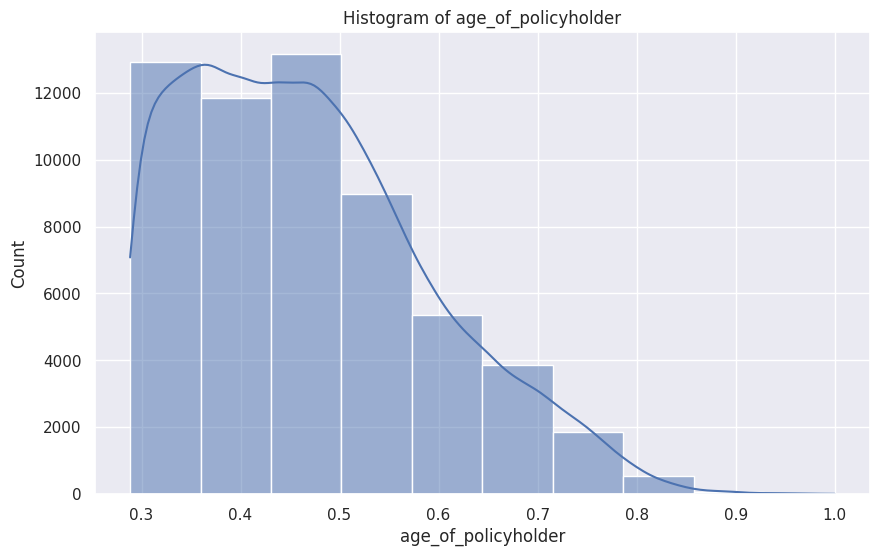

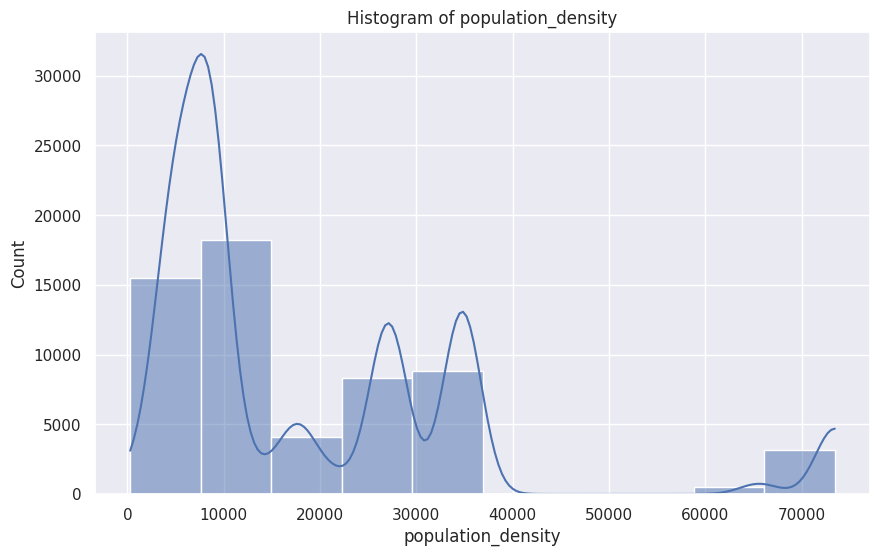

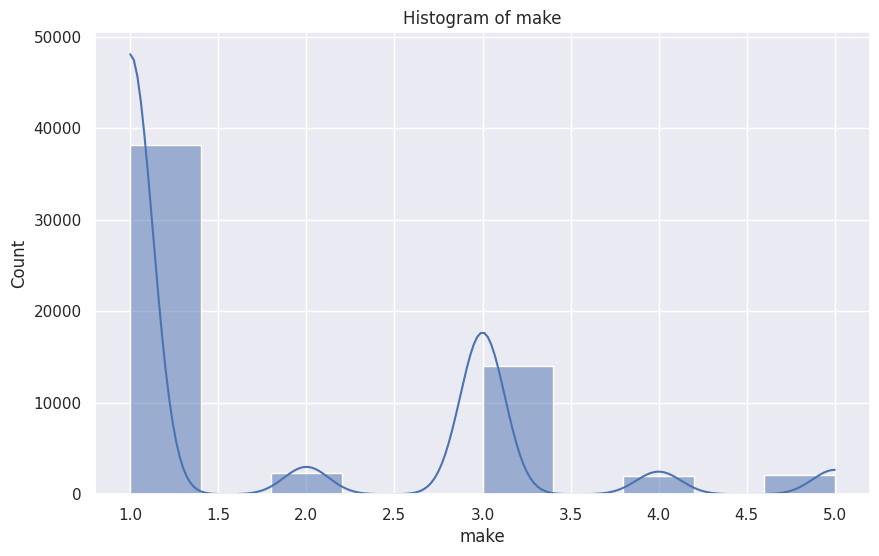

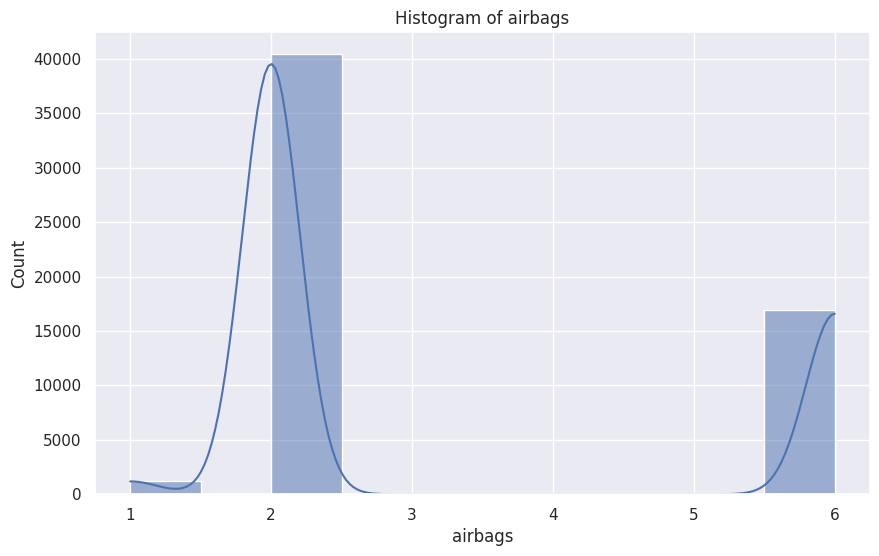

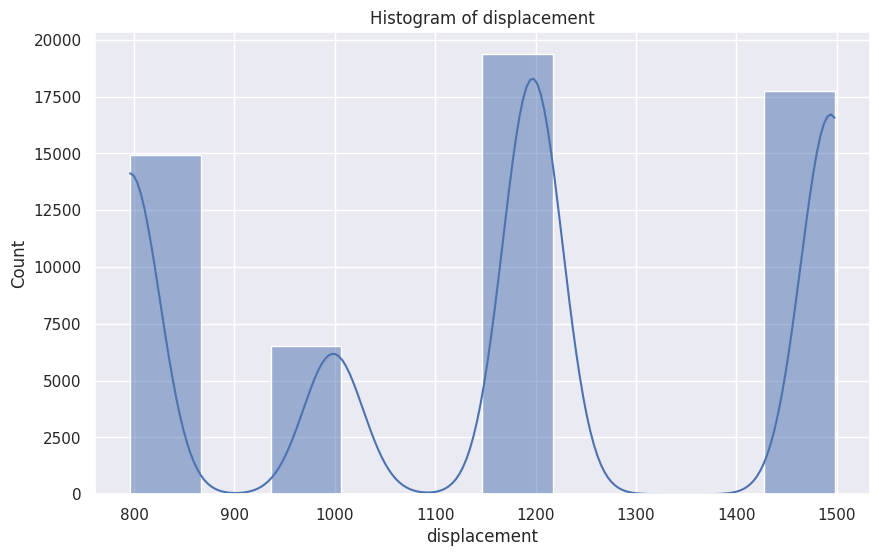

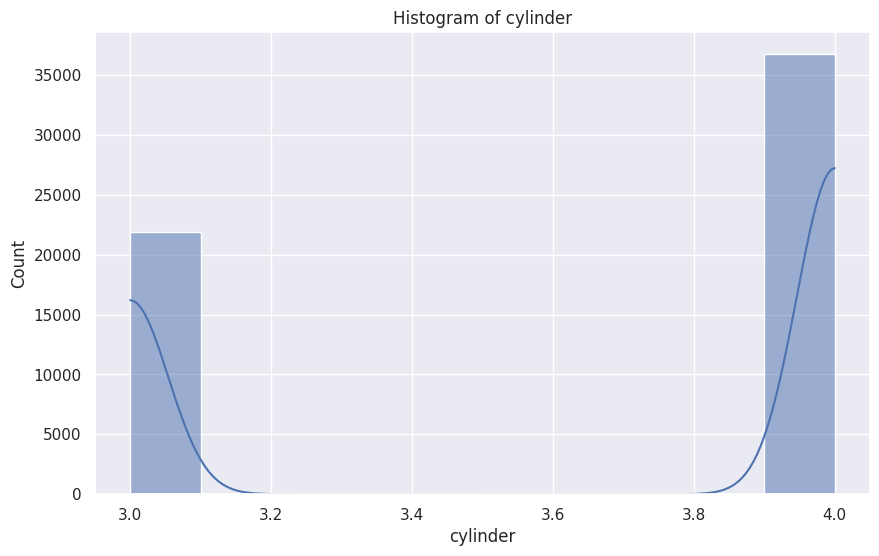

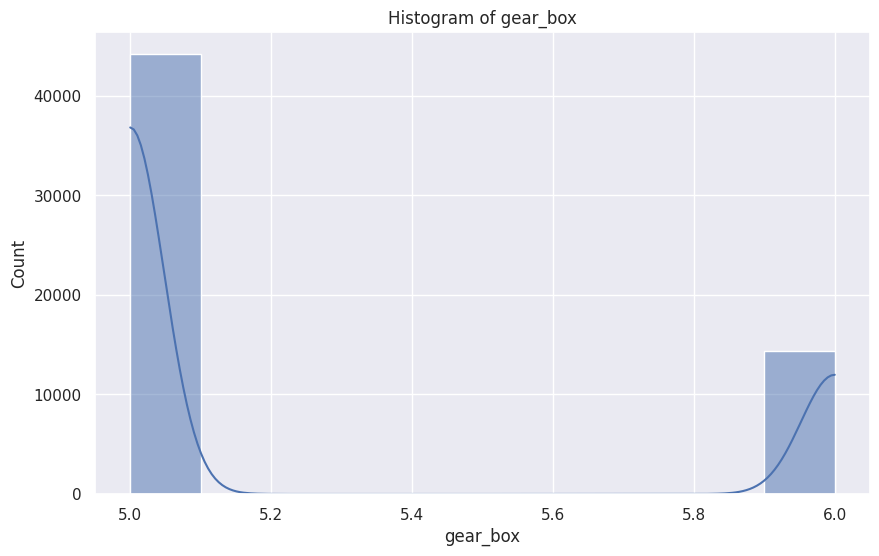

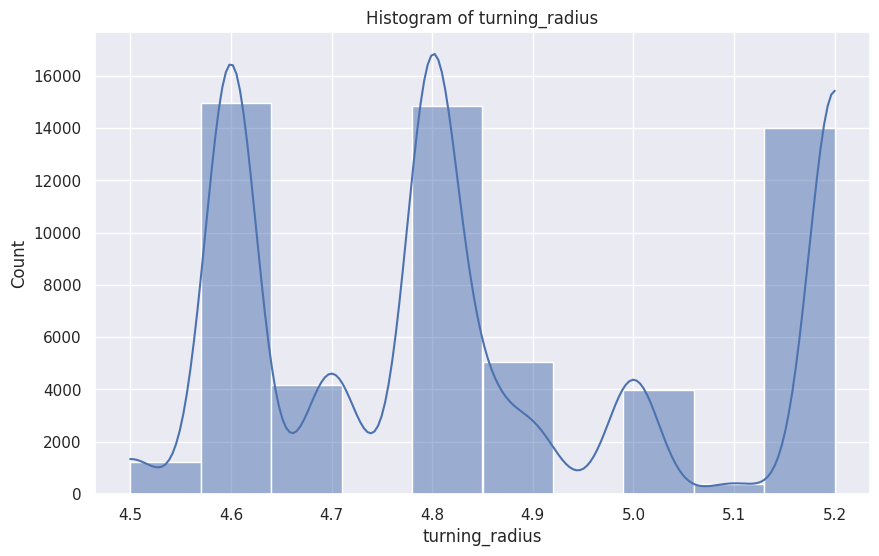

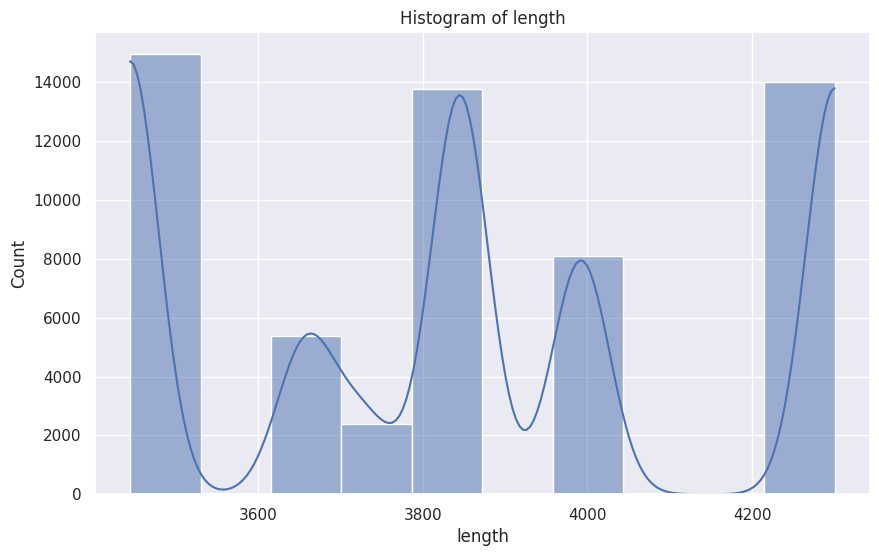

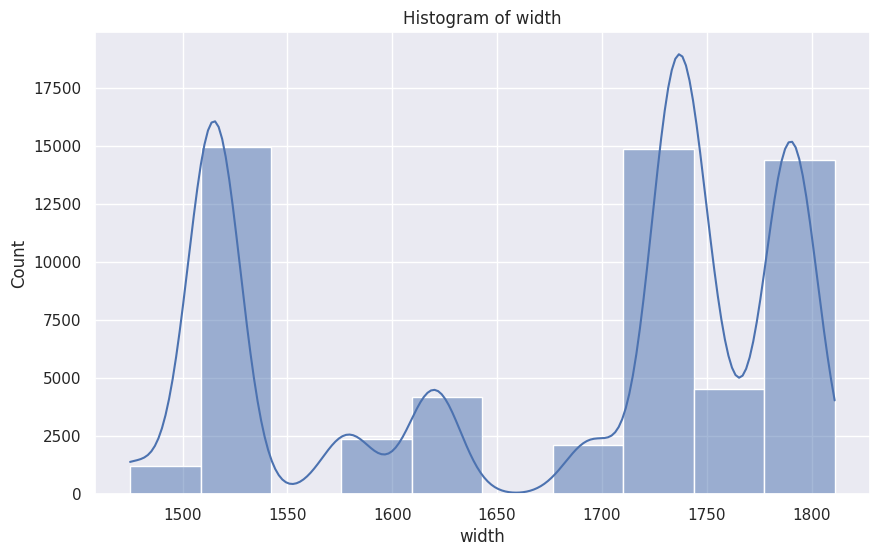

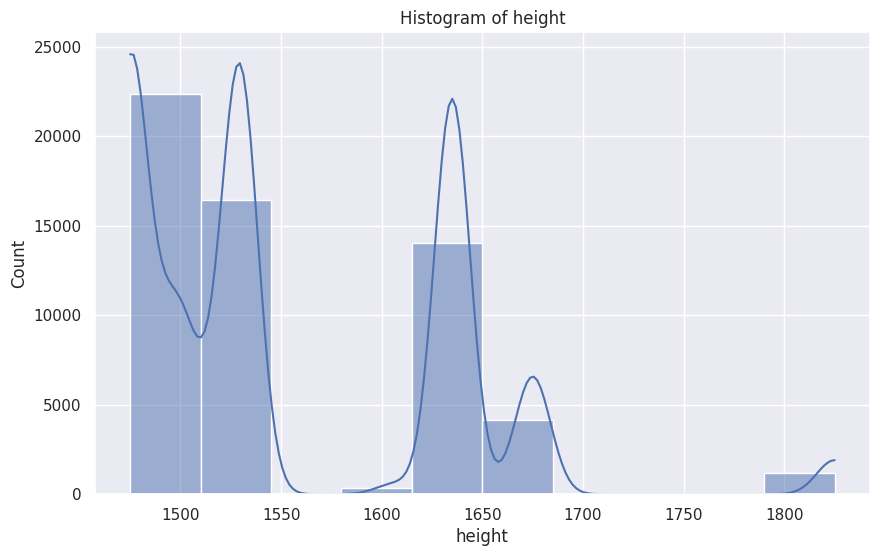

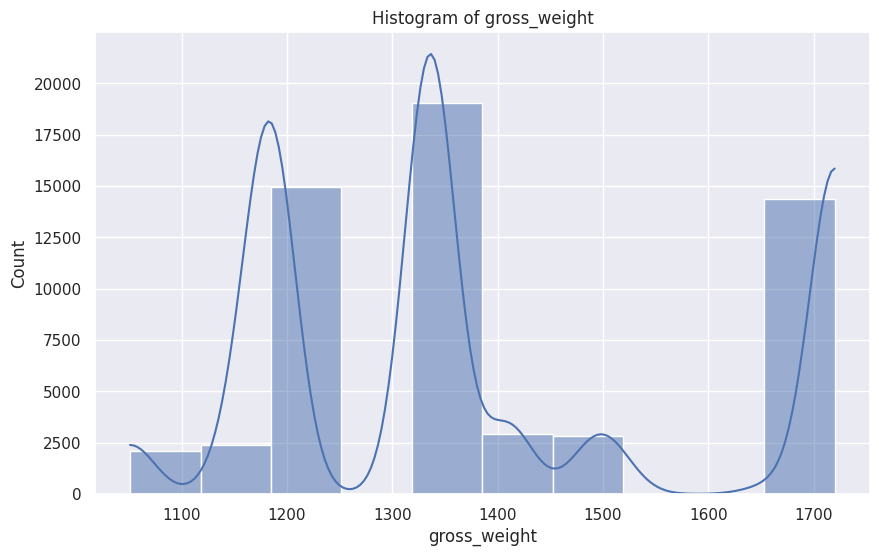

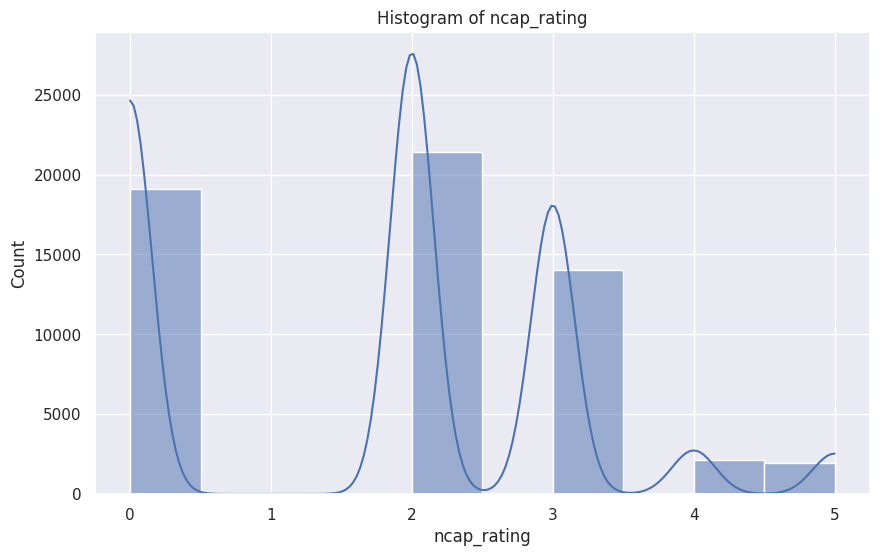

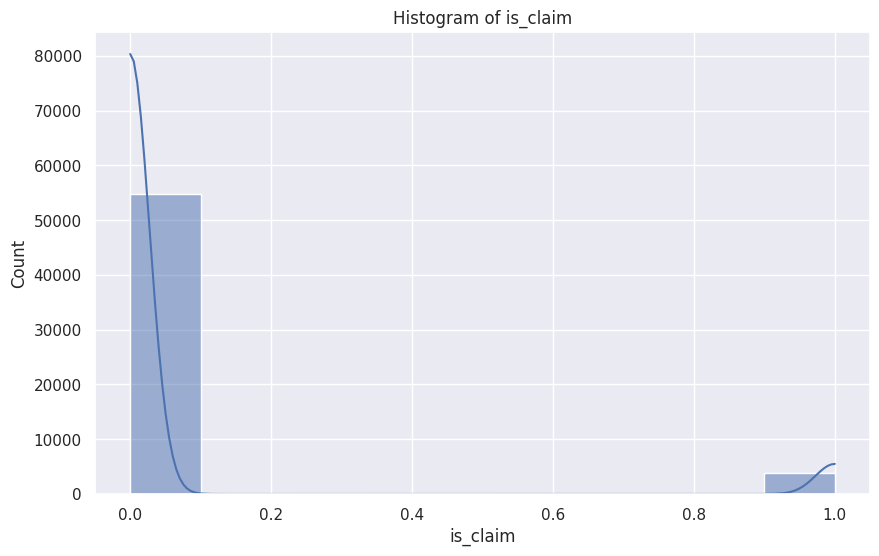

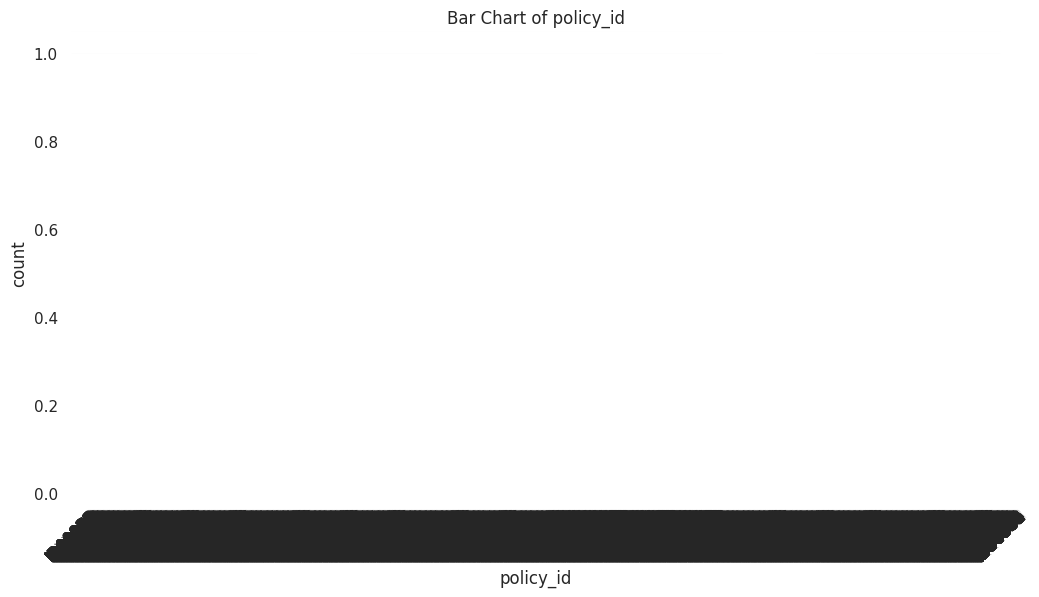

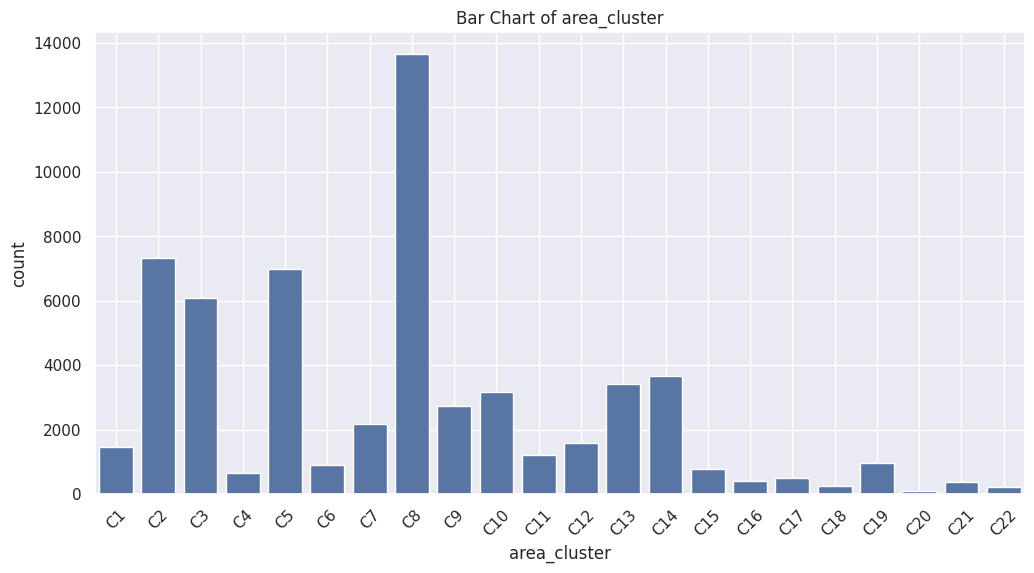

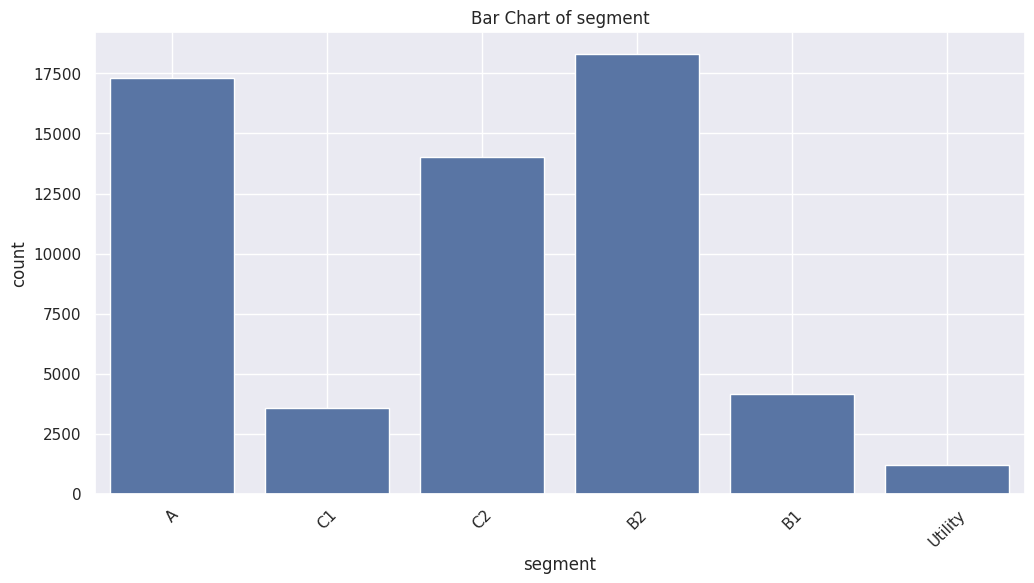

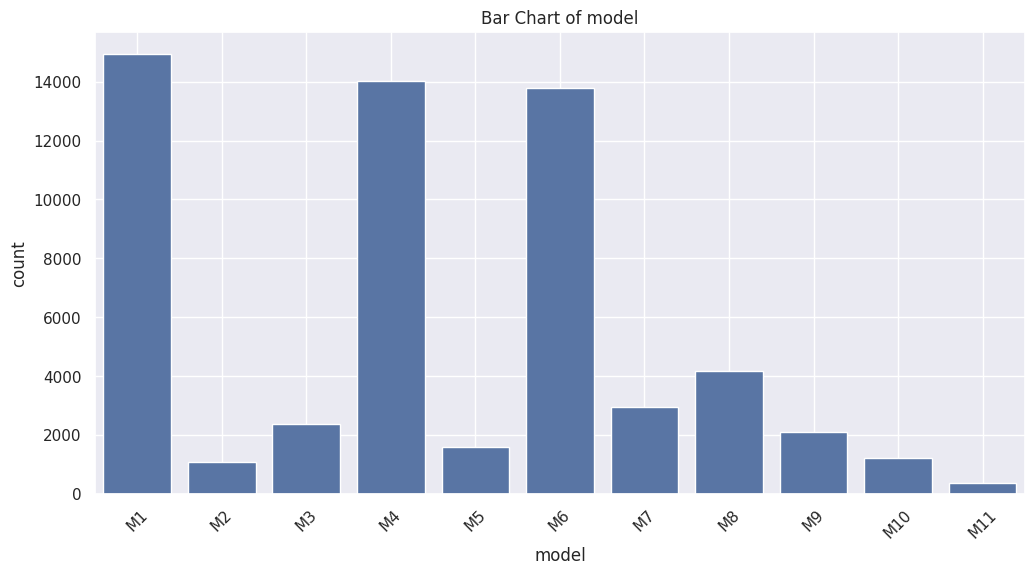

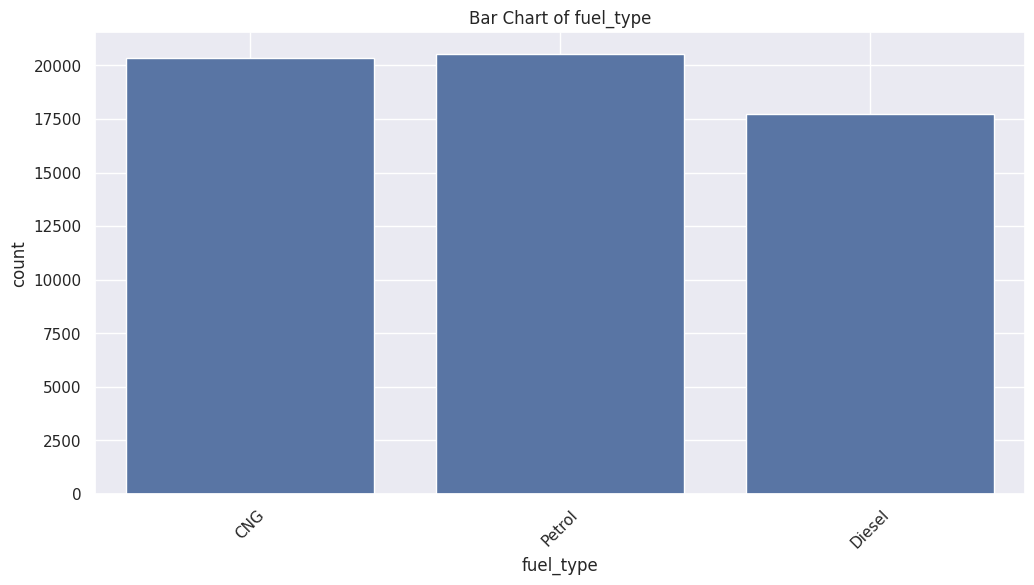

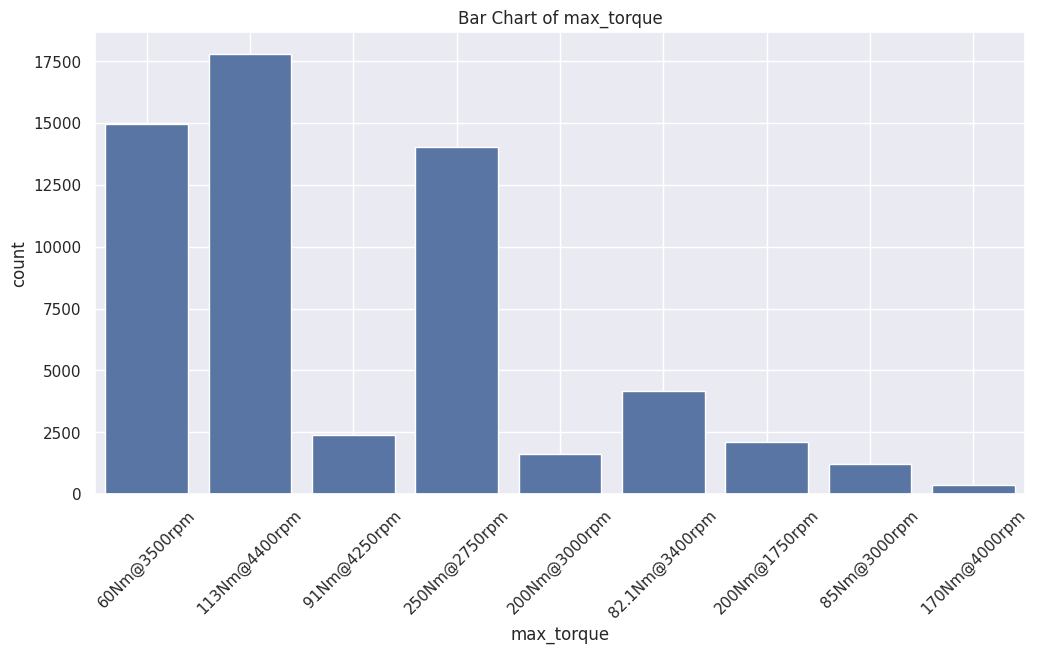

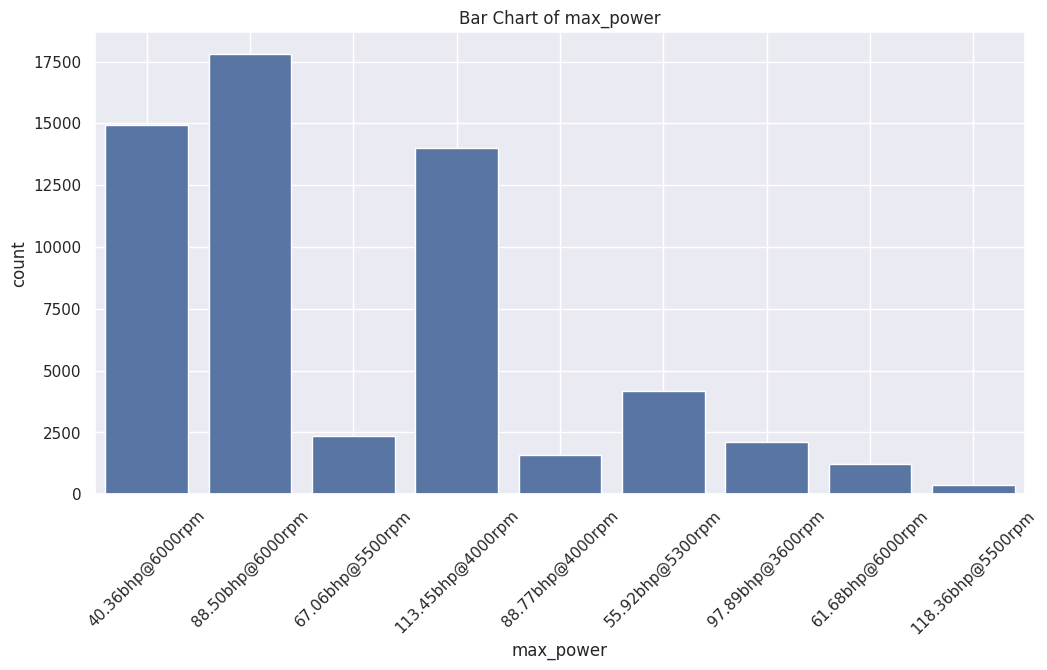

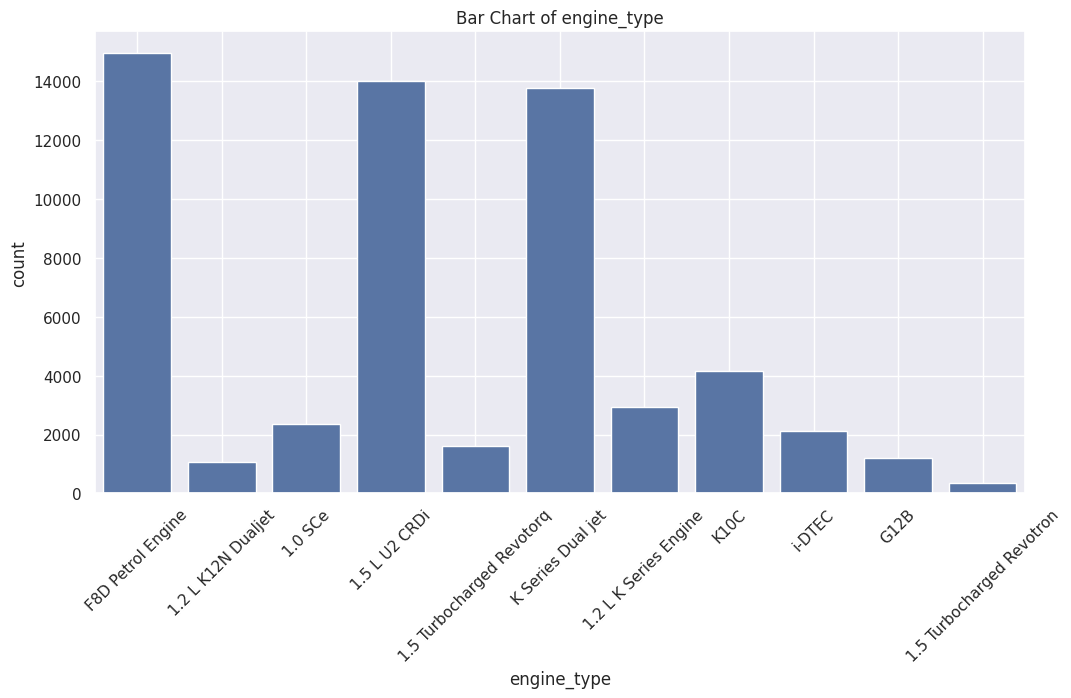

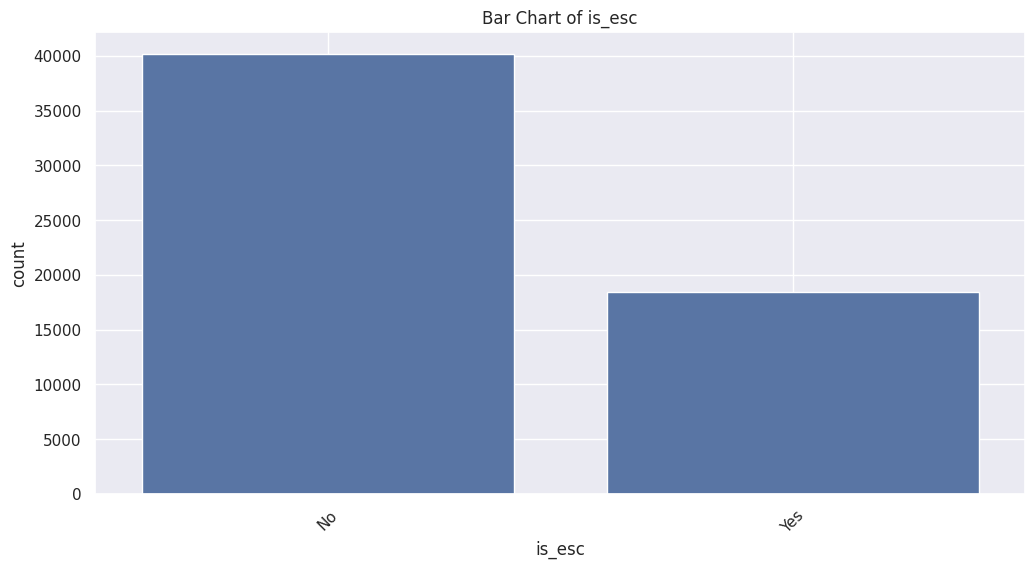

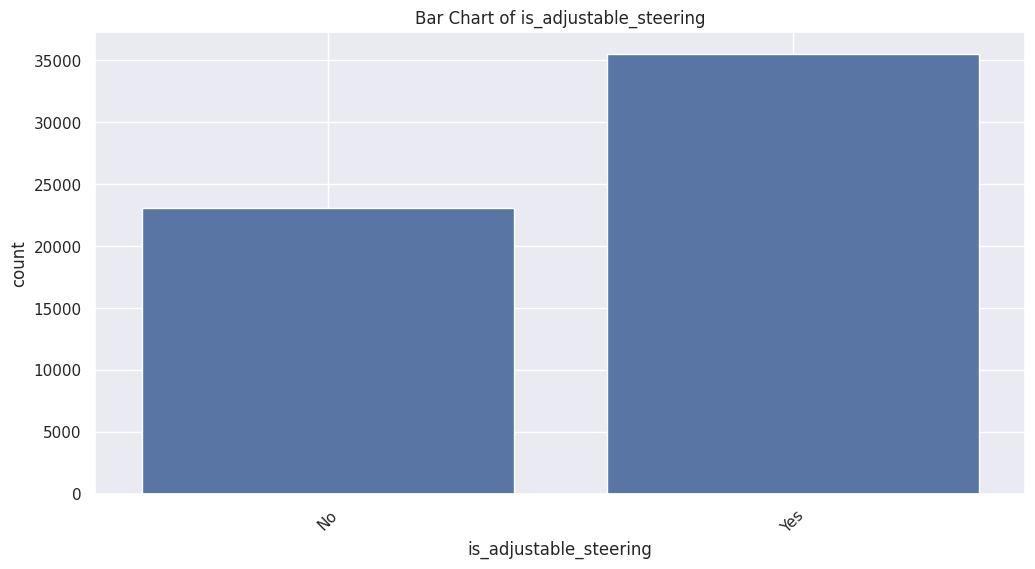

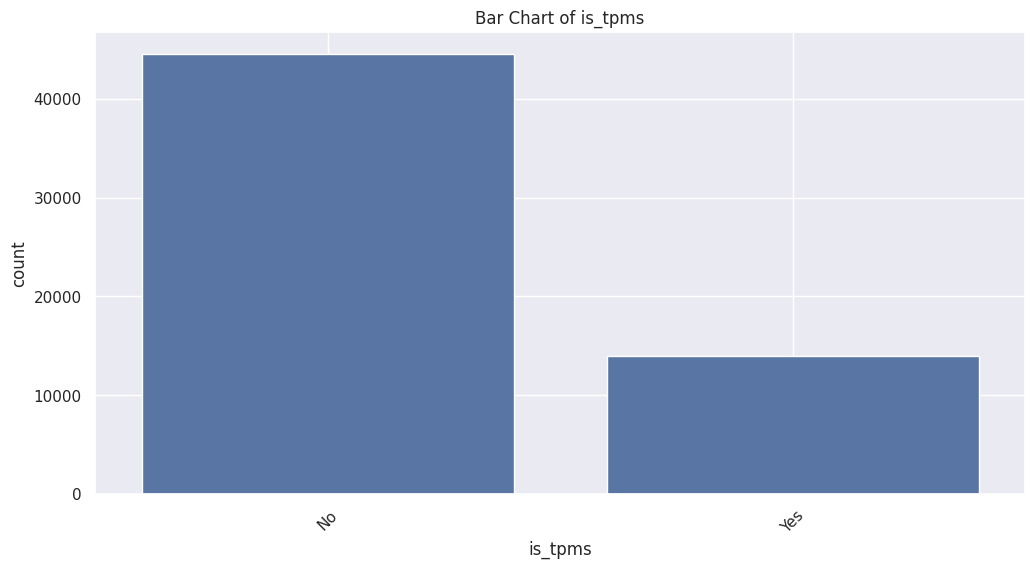

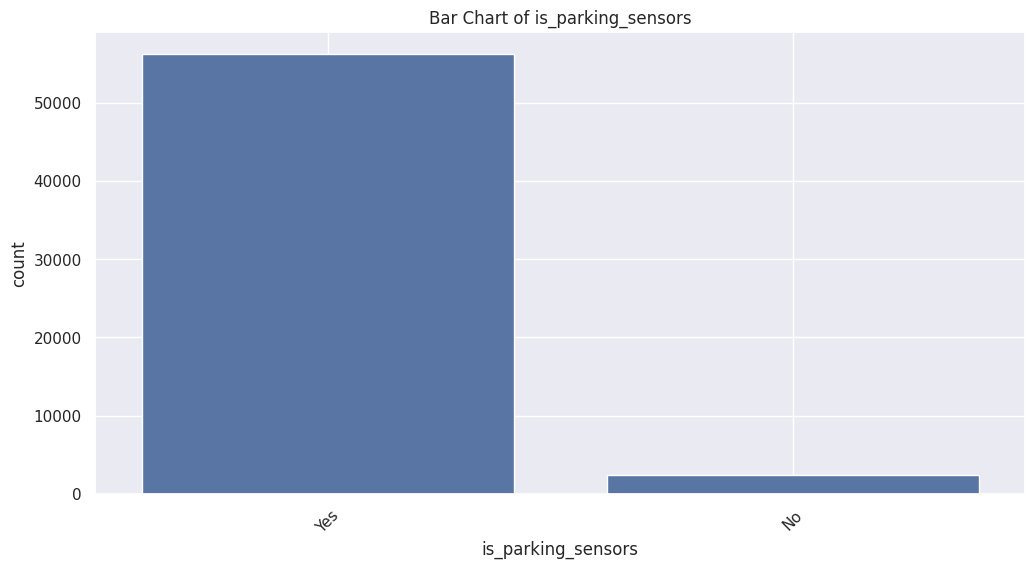

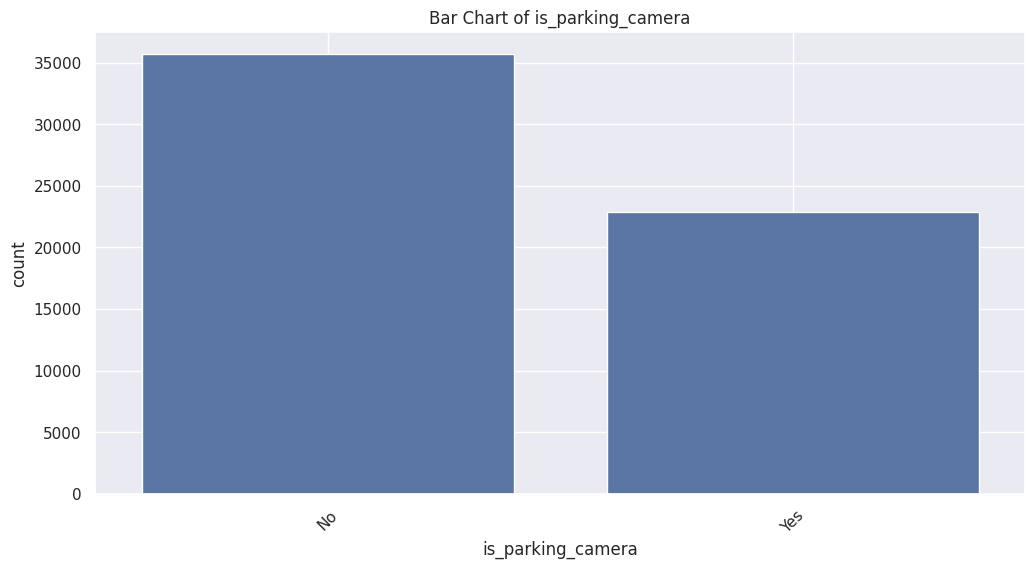

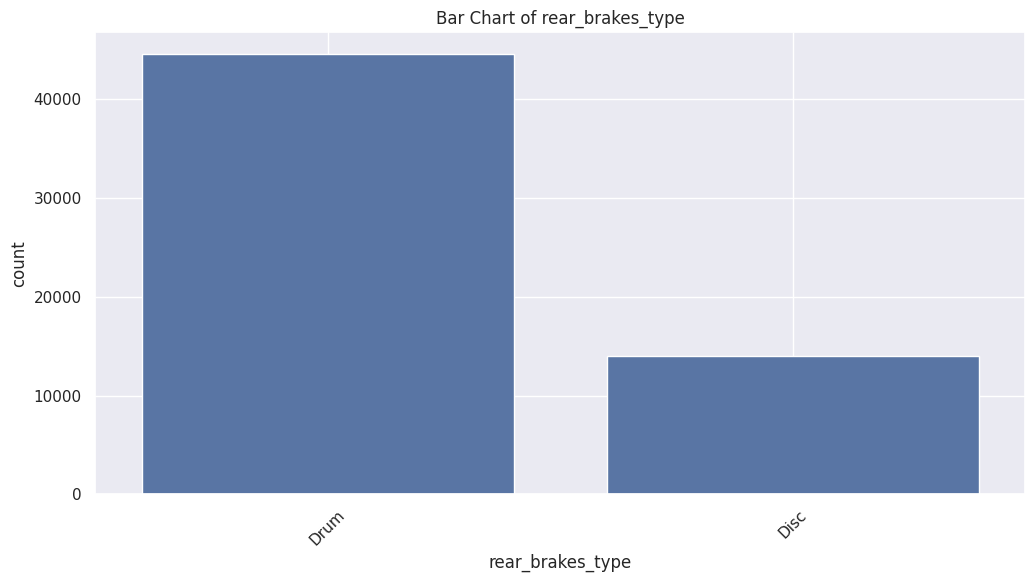

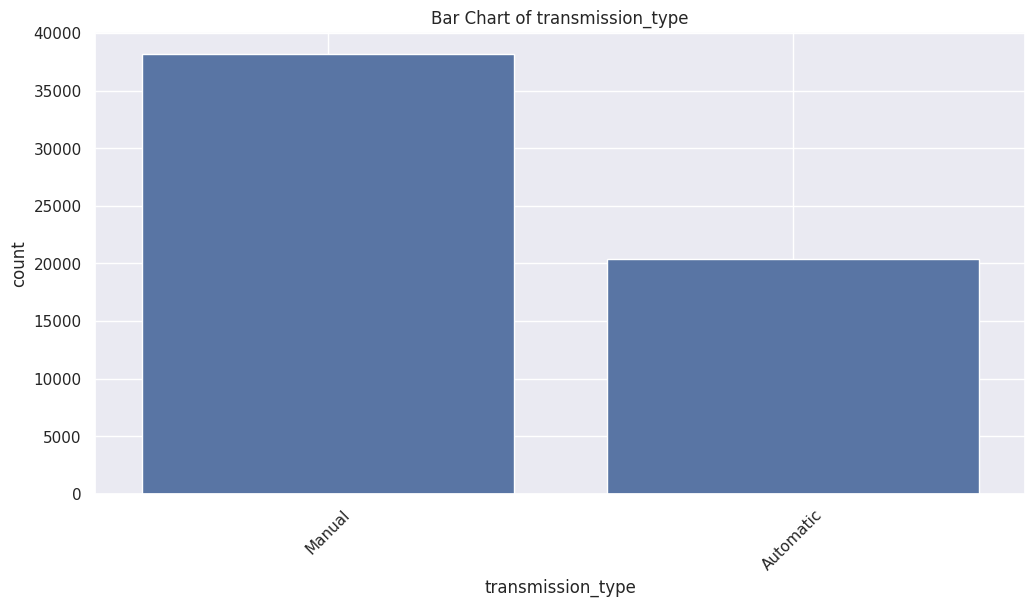

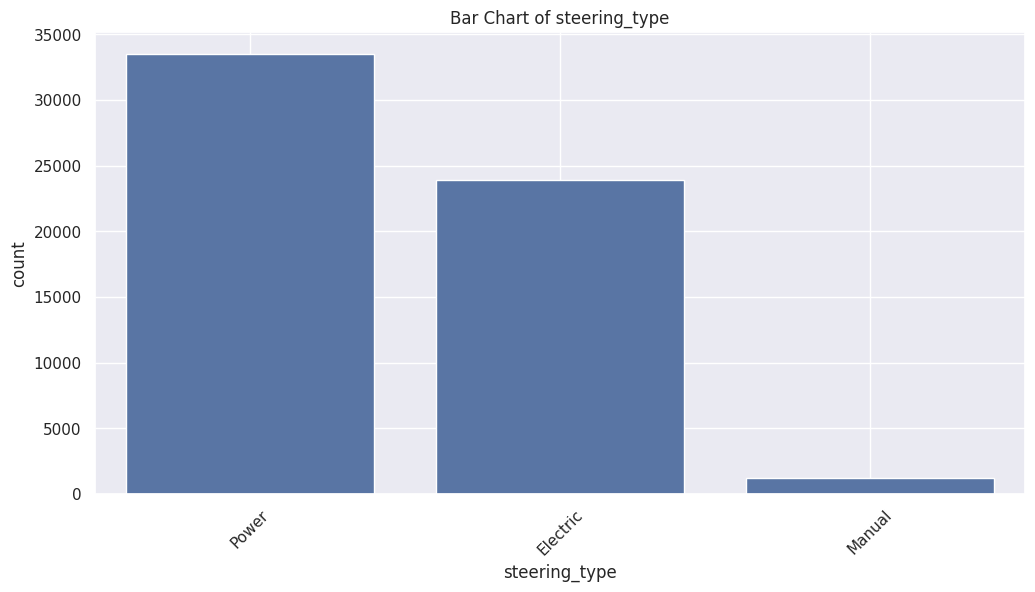

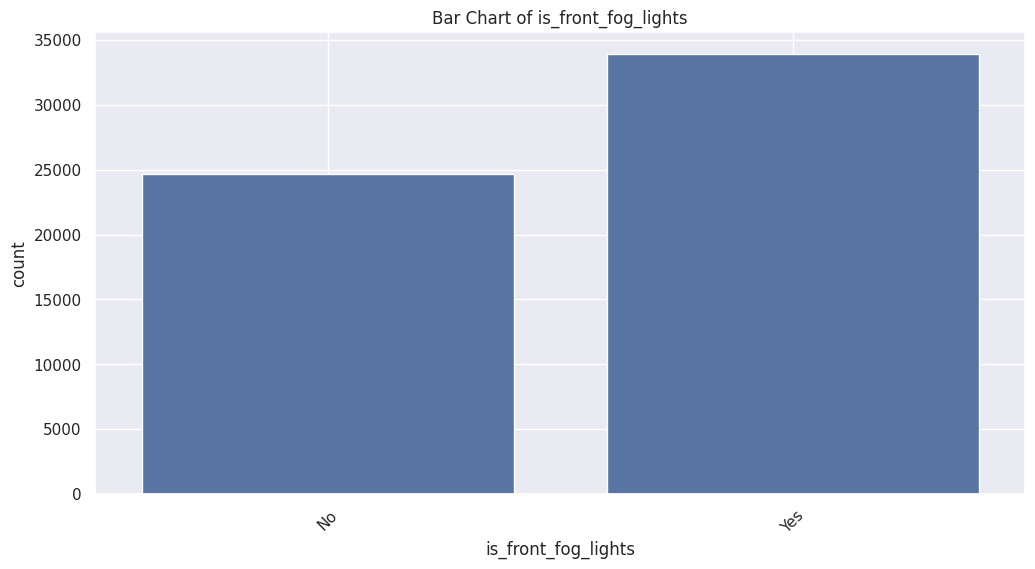

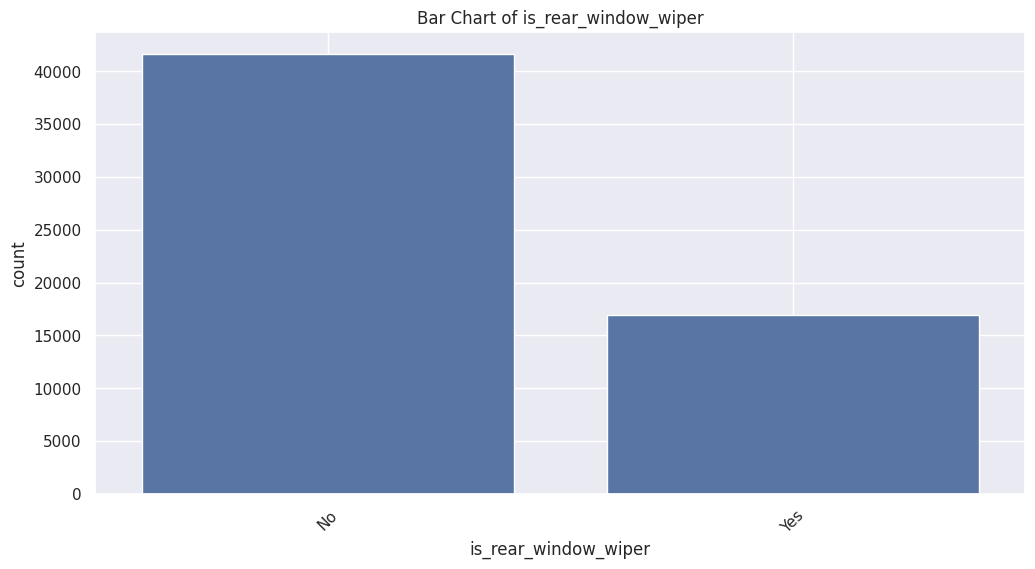

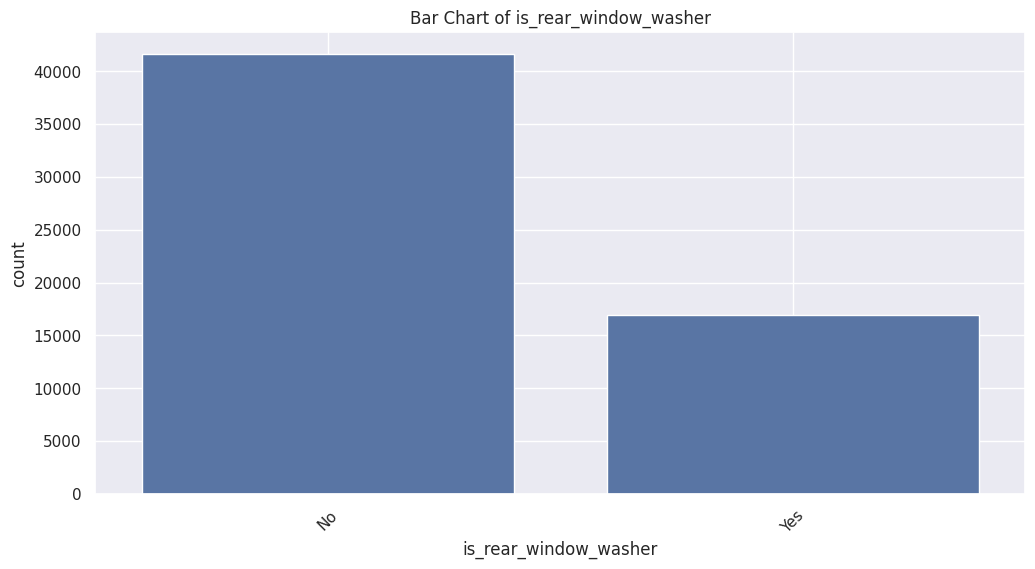

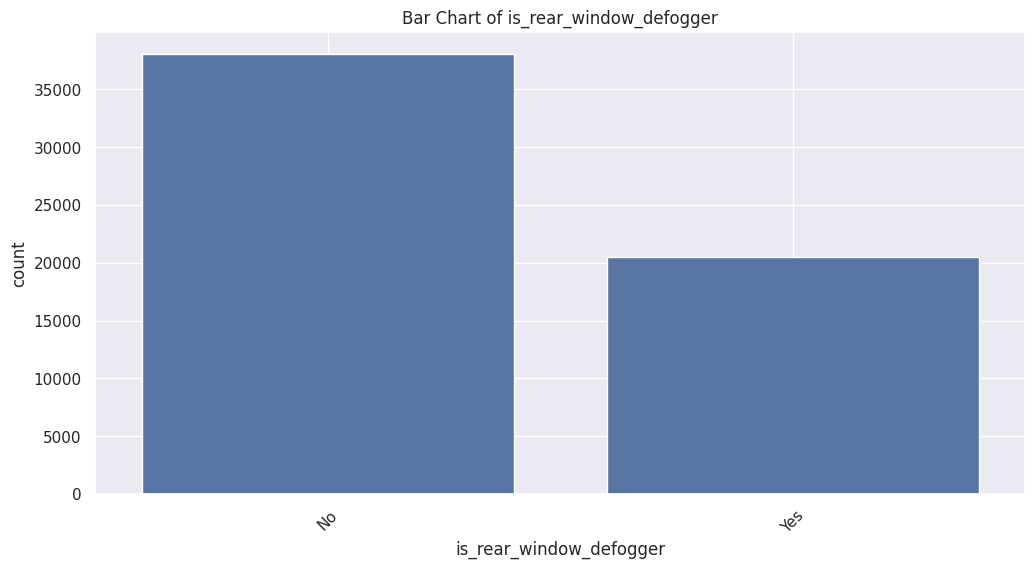

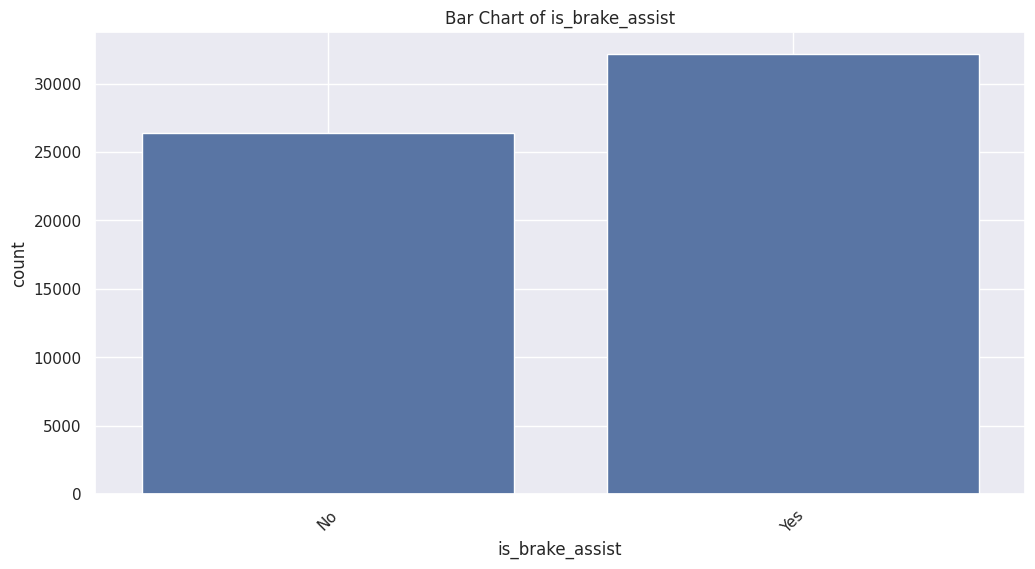

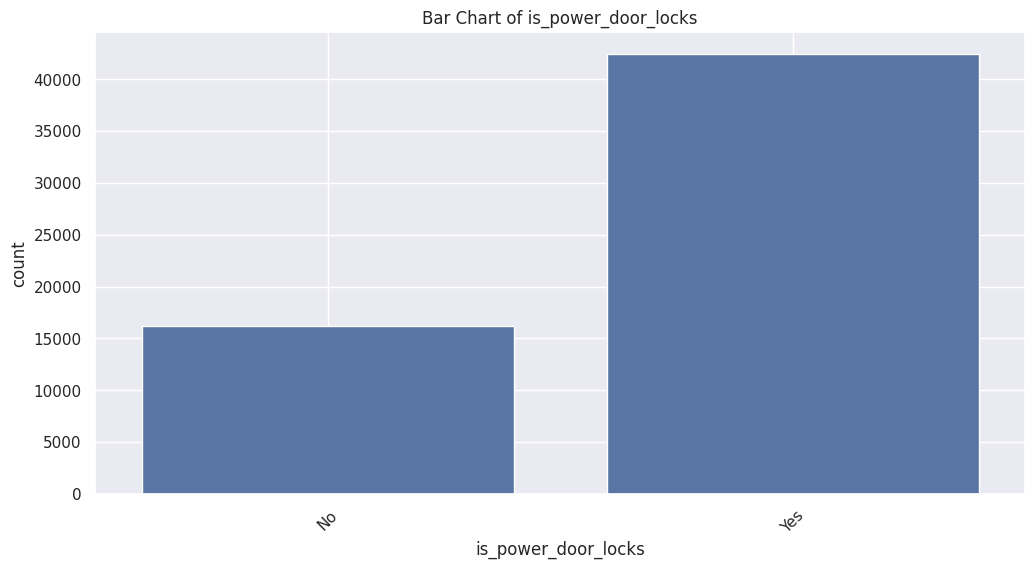

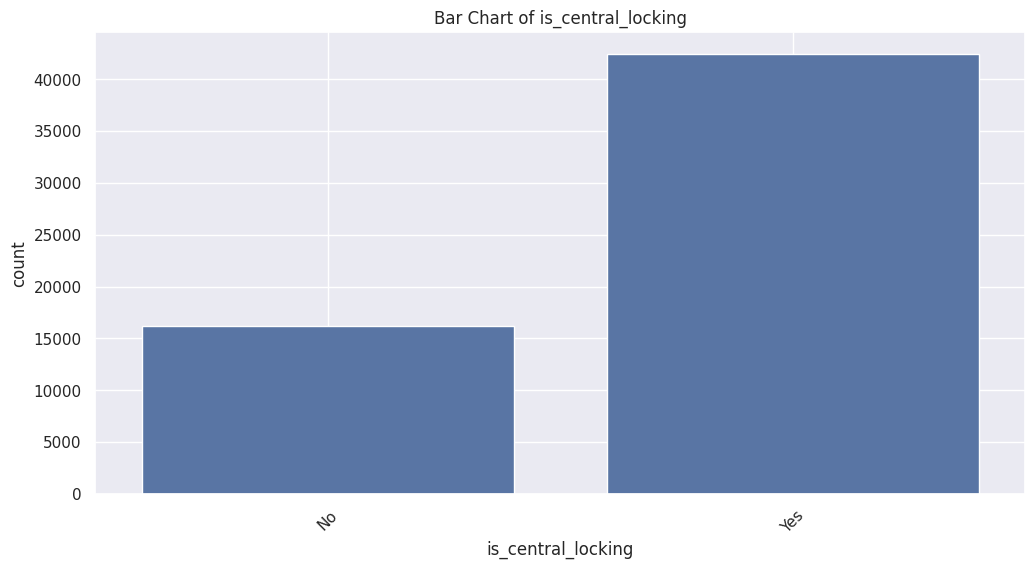

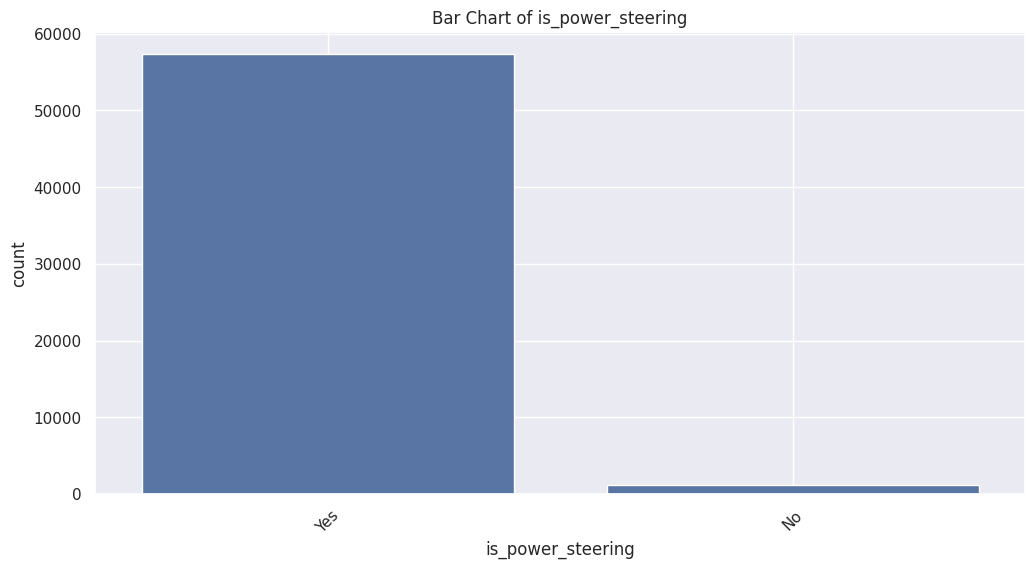

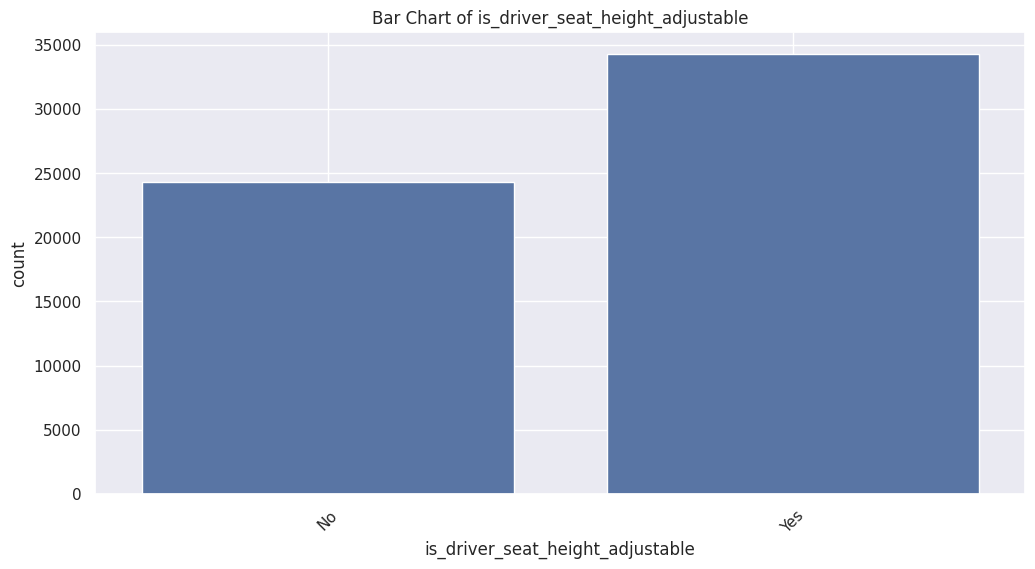

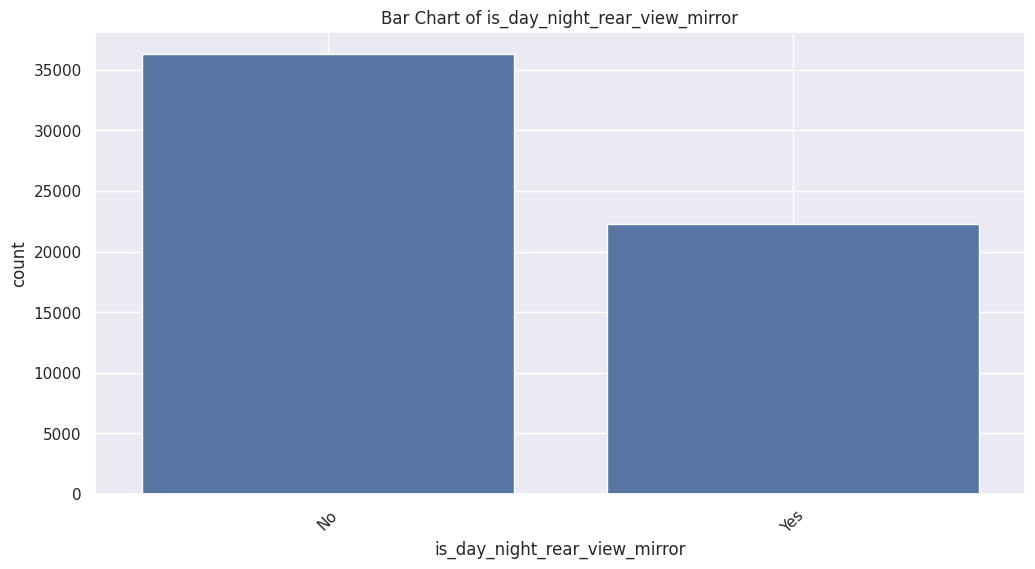

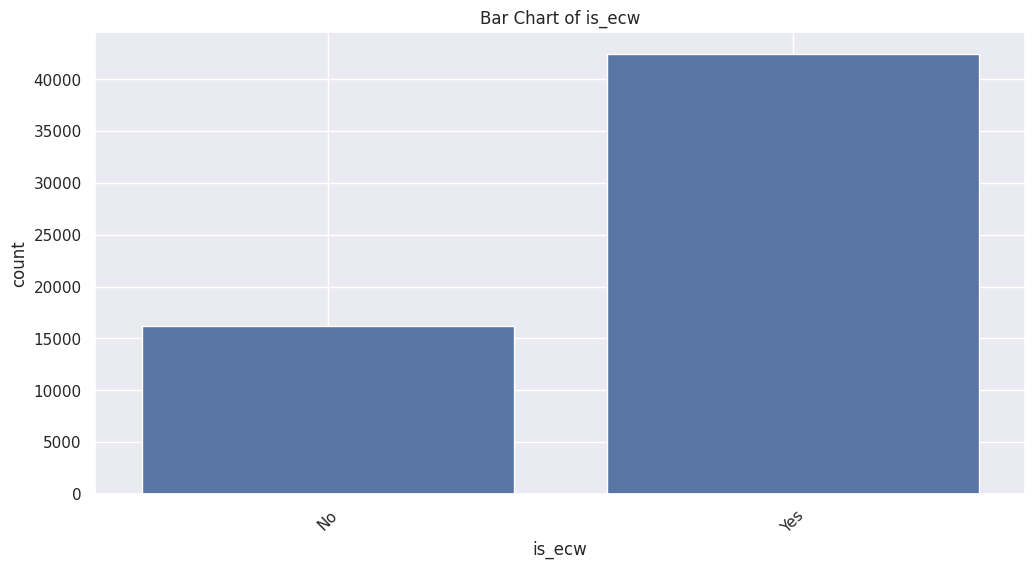

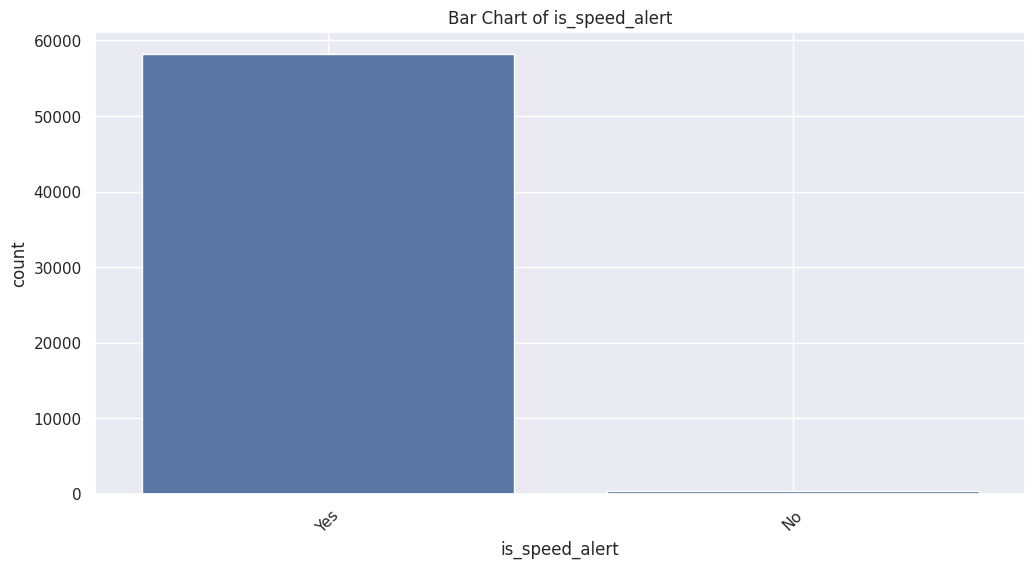

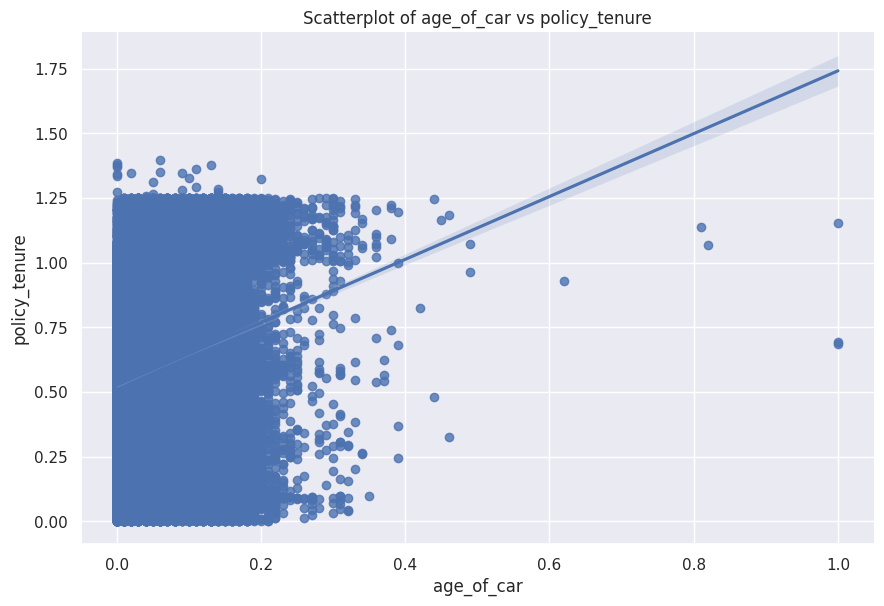

In [3]:
# Function to create count plot
def count_plot(data, column, title, palette=['magenta', 'limegreen']):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, hue=column, palette=palette, legend=False)
    plt.title(title)
    plt.show()

# Count plot for the target variable
count_plot(train_data, 'is_claim', 'Count Plot for the Target Variable')

# Function to create heatmap
def create_heatmap(data):
    numeric_df = data.select_dtypes(include='number')
    corr = numeric_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

# Heatmap for the training data
create_heatmap(train_data)

# Function to create box plots
def create_boxplots(data, columns):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data, y=column)
        plt.title(f'Boxplot of {column}')
        plt.grid(True)
        plt.show()

# Boxplots for selected numeric columns
create_boxplots(train_data, ['displacement', 'cylinder', 'gear_box', 'turning_radius', 'length', 'width', 'height', 'gross_weight', 'ncap_rating'])

# Function to create histograms
def create_histograms(data):
    numeric_df = data.select_dtypes(include='number')
    for column in numeric_df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[column], bins=10, kde=True)
        plt.title(f'Histogram of {column}')
        plt.grid(True)
        plt.show()

# Histograms for numeric columns
create_histograms(train_data)

# Function to create bar charts for categorical columns
def create_bar_charts(data):
    categorical_df = data.select_dtypes(include='object')
    for column in categorical_df.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=data, x=column)
        plt.title(f'Bar Chart of {column}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

# Bar charts for categorical columns
create_bar_charts(train_data)

# Function to create scatterplots
def create_scatterplots(data, x, y):
    sns.lmplot(data=data, x=x, y=y, height=6, aspect=1.5)
    plt.title(f'Scatterplot of {x} vs {y}')
    plt.show()

# Scatterplot of 'age_of_car' vs 'policy_tenure'
create_scatterplots(train_data, 'age_of_car', 'policy_tenure')

In [4]:
# Drop 'policy_id' column
train_data = train_data.drop(columns=['policy_id'])

# Map 'yes' to 1 and 'no' to 0
yes_no_columns = [col for col in train_data.columns if set(train_data[col].unique()) == {'Yes', 'No'}]
for column in yes_no_columns:
    train_data[column] = train_data[column].map({'Yes': 1, 'No': 0})

# One-hot encode categorical columns
categorical_columns = train_data.select_dtypes(include='object').columns
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

# Separate features and target variable
X = train_data_encoded.drop('is_claim', axis=1)
y = train_data_encoded['is_claim']

# Handle class imbalance using ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [5]:
# Split the resampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize models
rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)
gb = GradientBoostingClassifier()

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train models
rf.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)
gb.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_val)
lr_preds = lr.predict(X_val_scaled)
gb_preds = gb.predict(X_val)

# Evaluate models
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print()

evaluate_model("Random Forest", y_val, rf_preds)
evaluate_model("Logistic Regression", y_val, lr_preds)
evaluate_model("Gradient Boosting", y_val, gb_preds)

Random Forest Performance:
Accuracy: 0.9073
Precision: 0.8969
Recall: 0.9186
F1 Score: 0.9076

Logistic Regression Performance:
Accuracy: 0.5928
Precision: 0.5847
Recall: 0.6158
F1 Score: 0.5999

Gradient Boosting Performance:
Accuracy: 0.9048
Precision: 0.9390
Recall: 0.8640
F1 Score: 0.9000



In [6]:
# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
}

# Initialize XGBoost model
xgb = XGBClassifier(eval_metric='logloss')

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train XGBoost with best parameters
xgb_best = XGBClassifier(eval_metric='logloss', 
                         learning_rate=0.2, max_depth=10, n_estimators=400)
xgb_best.fit(X_resampled, y_resampled)

# Make predictions and evaluate XGBoost
y_pred_val = xgb_best.predict(X_val)
evaluate_model("XGBoost with Best Parameters", y_val, y_pred_val)

In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_best, X_resampled, y_resampled, cv=5)
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Calculate ROC-AUC
y_pred_prob = xgb_best.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the model
joblib.dump(xgb_best, 'xgboost_model.pkl')

# Predict on the test set with optimal threshold
y_pred_prob_test = xgb_best.predict_proba(X_test)[:, 1]
optimal_threshold = 0.37027785
y_pred_test = (y_pred_prob_test >= optimal_threshold).astype(int)

# Save predictions to CSV
predictions_df = pd.DataFrame({'predicted_label': y_pred_test})
predictions_df.to_csv('predictions.csv', index=False)

In [ ]:
# Confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Final metrics for test set
evaluate_model("XGBoost with Best Parameters (Test Set)", y_test, y_pred_test)